In [1]:
## week 3 _ 08_01
## reference : https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4


In [2]:
## import package

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor


In [4]:
## data load

In [5]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

## Exploratory Visualization


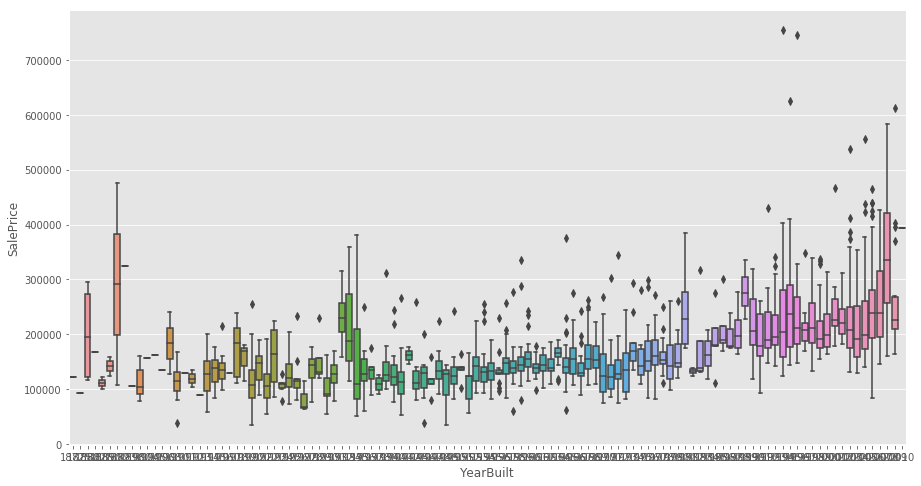

In [6]:
plt.figure(figsize=(15,8)) # plt 그리는 size 설정하고
sns.boxplot(train.YearBuilt, train.SalePrice) # sns의 boxplot을 이용해 그림
## box plot 설명 : http://www.physics.csbsju.edu/stats/box2.html

(0, 800000)

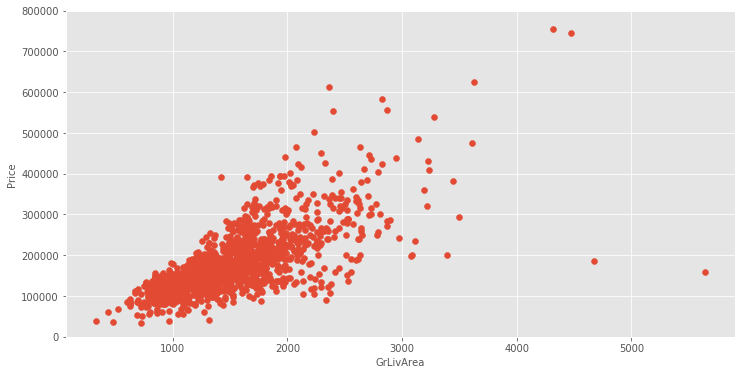

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea,y=train.SalePrice)
plt.xlabel('GrLivArea',fontsize=10)
plt.ylabel('Price',fontsize=10)
plt.ylim(0,800000)


In [8]:
train.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index,inplace=True)

(0, 800000)

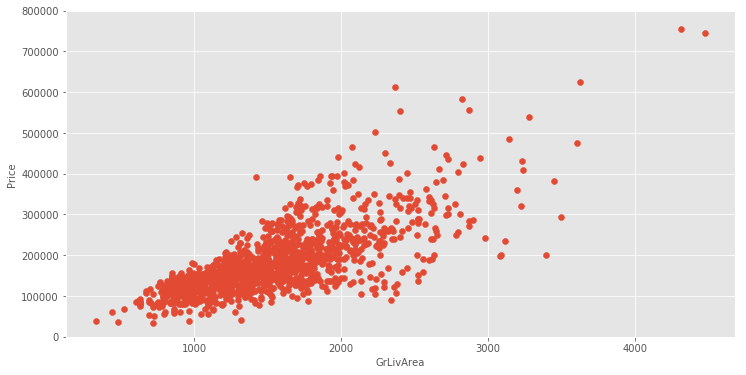

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea,y=train.SalePrice)
plt.xlabel('GrLivArea',fontsize=10)
plt.ylabel('Price',fontsize=10)
plt.ylim(0,800000)

In [10]:
full = pd.concat([train,test],ignore_index=True)
## https://pandas.pydata.org/pandas-docs/stable/merging.html


In [11]:
#colnames 가 알고싶다
##my_dataframe.columns.values
full.columns.values

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces',
       'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC',
       'HouseStyle', 'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape',
       'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea',
       'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive',
       'PoolAre

In [12]:
full.drop(['Id'],axis=1,inplace=True)


In [13]:
full.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [14]:
full.shape

(2917, 80)

## data Cleaning

## (1) missing data

In [15]:
aa = full.isnull().sum()

In [16]:
# full.isnull().sum()
# col 별 sum을 결과내주네

In [17]:
type(aa)

pandas.core.series.Series

In [18]:
aa[aa>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [19]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [20]:
full['LotAreaCut']=pd.qcut(full.LotArea,10)
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [21]:
full['LotFrontage'] = full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))

In [22]:
full['LotFrontage'] = full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))
# 아마 na 값을 그 구간의 중앙값으로 넣는 구나.

In [23]:
# then we filling in other missing values according to data_description


In [24]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

In [25]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

In [26]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)
    
## 제일 처음값으로 넣어도 되나? mode가 뭘 의미하지?

In [27]:
full['KitchenQual'].mode()

0    TA
dtype: object

In [28]:
# is missing data still here?
full.isnull().sum()[full.isnull().sum()>0]
# 이 부분은 test data 임

SalePrice    1459
dtype: int64

## Feature Engineering

In [29]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

In [30]:
## 각 값마다 고유의 class 를 나타낼 수 있는 것들이 있다면 다음과 같이 매핑


In [31]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

In [32]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"

In [33]:
map_values()

'Done!'

In [34]:
# drop two unwanted columns 

In [35]:
full.drop('LotAreaCut',axis=1,inplace=True)

In [36]:
full.drop(['SalePrice'],axis=1,inplace=True)

## Pipeline

In [43]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        lab=LabelEncoder()
        X['YearBuilt'] = lab.fit_transform(X['YearBuilt'])
        X['YearRemodAdd'] = lab.fit_transform(X['YearRemodAdd']
                                             )
        X['GarageYrBlt'] = lab.fit_transform(X['GarageYrBlt'])
        return X
    

In [44]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [45]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [46]:
full2 = full.copy()

In [47]:
data_pipe = pipe.fit_transform(full2)

In [48]:
data_pipe.shape

(2917, 405)

In [49]:
data_pipe.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,854,0.0,706.0,0.0,150.0,0.000000,0,2,548.0,...,1,0,1,1,0,0,0,1,0,0
1,7.141245,0,0.0,978.0,0.0,284.0,0.000000,1,2,460.0,...,1,0,1,1,0,0,1,0,0,0
2,6.825460,866,0.0,486.0,0.0,434.0,0.000000,1,2,608.0,...,1,0,1,1,0,0,0,1,0,0
3,6.869014,756,0.0,216.0,0.0,540.0,5.609472,1,1,642.0,...,1,0,1,1,0,1,0,0,0,0
4,7.044033,1053,0.0,655.0,0.0,490.0,0.000000,1,2,836.0,...,1,0,1,1,0,0,0,1,0,0


In [56]:
scaler = RobustScaler()

In [57]:
train.shape

(1458, 81)

In [59]:
n_train = train.shape[0]

x = data_pipe[:n_train]
test_x = data_pipe[n_train:]
y = train.SalePrice

x_scaled = scaler.fit(x).transform(x)
y_log = np.log(train.SalePrice)
test_x_scaled = scaler.transform(test_x)

In [61]:
lasso=Lasso(alpha=0.001)
lasso.fit(x_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [62]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

In [63]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,0.108870
OverallQual,0.102583
2ndFlrSF,0.074221
YearBuilt,0.068926
1stFlrSF,0.059760
Functional_Typ,0.051862
TotalBsmtSF,0.050261
Neighborhood_Crawfor,0.049942
OverallCond,0.045527
oNeighborhood,0.044311


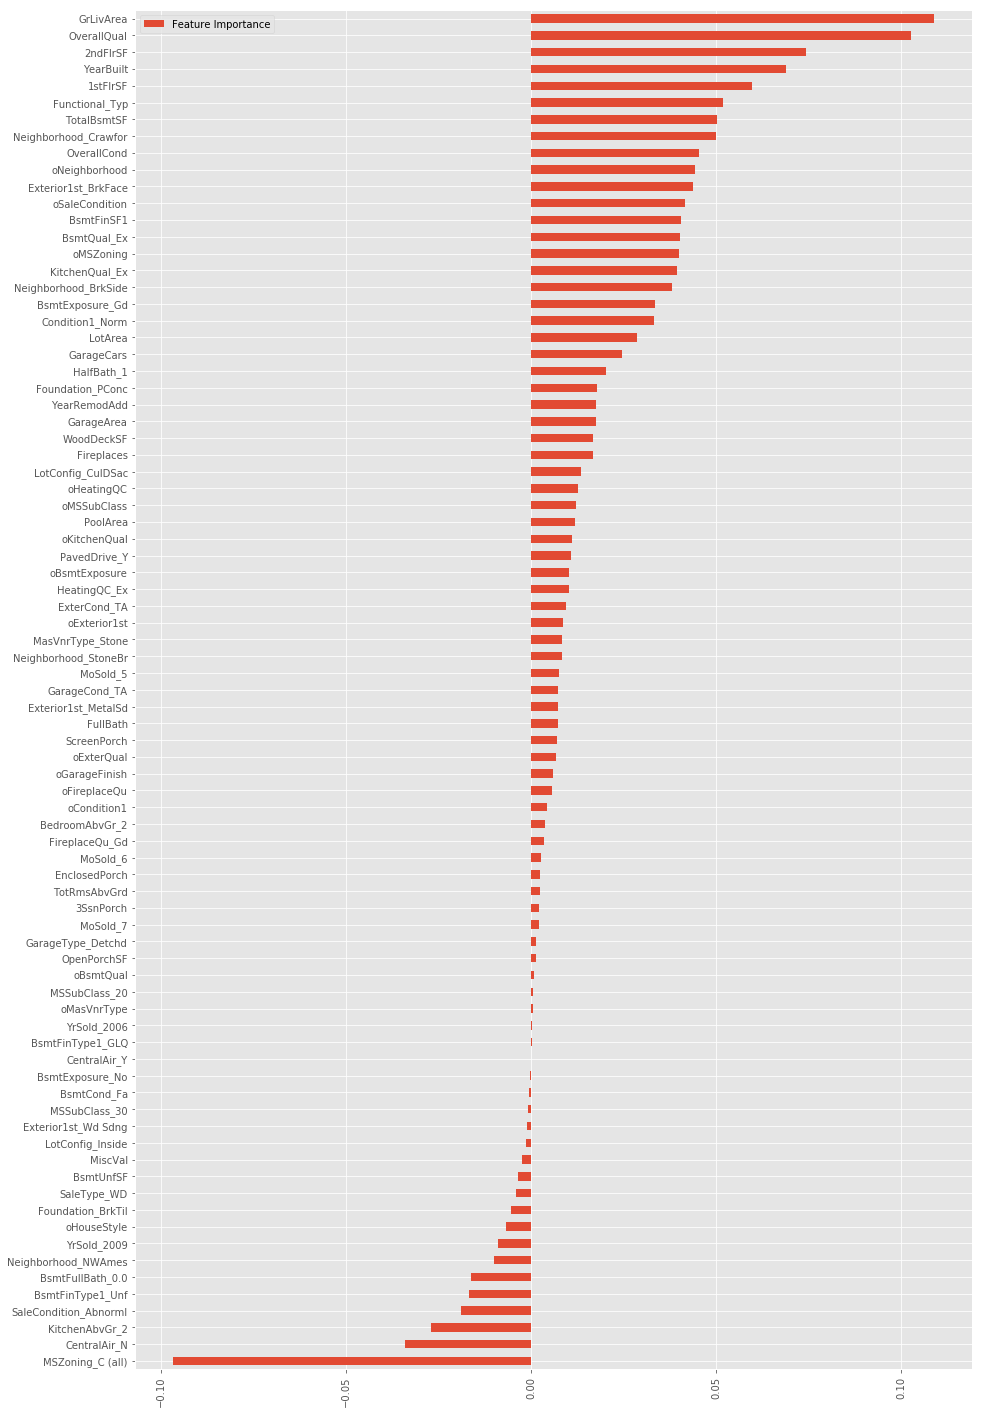

In [64]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [66]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            return X

In [67]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [70]:
full_pipe = pipe.fit_transform(full)

In [71]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [72]:
pca = PCA(n_components=410)

In [73]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [74]:
X_scaled.shape, test_X_scaled.shape

((1458, 410), (1459, 410))

In [75]:
## Modeling & Evaluation 

In [76]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [77]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [78]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 1026870159.526766, 488528070.4534
Ridge: 0.117596, 0.0091
Lasso: 0.121474, 0.0060
RF: 0.138784, 0.0068
GBR: 0.124116, 0.0075
SVR: 0.112727, 0.0047
LinSVR: 0.119878, 0.0089
Ela: 0.111113, 0.0059
SGD: 0.165057, 0.0169
Bay: 0.110577, 0.0060
Ker: 0.109276, 0.0055
Extra: 0.137129, 0.0040
Xgb: 0.126921, 0.0066


In [80]:
## Grid Search
# http://blog.naver.com/PostView.nhn?blogId=laonple&logNo=220576650094&parentCategoryNo=&categoryNo=22&viewDate=&isShowPopularPosts=true&from=search


In [81]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [82]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11129660796478721
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111463        0.001392
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111297        0.001339
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111538        0.001284
3  {'alpha': 0.0009, 'max_iter': 10000}         0.111915        0.001206


In [83]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.11020174961498394
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110375        0.001268
1  {'alpha': 40}         0.110305        0.001249
2  {'alpha': 45}         0.110258        0.001235
3  {'alpha': 50}         0.110227        0.001223
4  {'alpha': 55}         0.110209        0.001213
5  {'alpha': 60}         0.110202        0.001205
6  {'alpha': 65}         0.110203        0.001198
7  {'alpha': 70}         0.110212        0.001192
8  {'alpha': 80}         0.110247        0.001184
9  {'alpha': 90}         0.110301        0.001178


In [84]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.11020174961498394
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110375        0.001268
1  {'alpha': 40}         0.110305        0.001249
2  {'alpha': 45}         0.110258        0.001235
3  {'alpha': 50}         0.110227        0.001223
4  {'alpha': 55}         0.110209        0.001213
5  {'alpha': 60}         0.110202        0.001205
6  {'alpha': 65}         0.110203        0.001198
7  {'alpha': 70}         0.110212        0.001192
8  {'alpha': 80}         0.110247        0.001184
9  {'alpha': 90}         0.110301        0.001178


In [85]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.1082697361476592
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.108270   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.108509   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.108399   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.108278   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.108762   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.108299   

   std_test_score  
0        0.001209  
1        0.001243  
2        0.001189  
3        0.001210  
4        0.001181  
5        0.001191  


In [86]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11117135158453563
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.114762   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.114250   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.112062   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111278   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.111209   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.112483   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.111171   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.111192   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.112983   

   std_test_score  
0        0.001937  
1        0.001904  
2        0.001596  
3        0.001382  
4        0.001326  
5        0.001160  
6        0.001312  
7        0.001277  
8        0.0011

In [87]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

# assign weights based on their gridsearch score
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10768459878025709


In [88]:
## stacking

In [89]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [90]:
# must do imputer first, otherwise stacking won't work, and i don't know why.
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

score = rmse_cv(stack_model,a,b)
print(score.mean())

0.10657571091494455


In [91]:
## submission

In [92]:
# This is the final model I use
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [93]:
pred = np.exp(stack_model.predict(test_X_scaled))

result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)

In [94]:
## 80%~ understood. but still to review and repeat